In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import isamcalc_lib as isam
from netCDF4 import Dataset as NetCDFFile
import copy as cp
from numba import jit


In [2]:
fname = 'mangrove_hmax95_us.nc4'
varname = 'Band1'


In [6]:
# Create x axis for file
step = (29.8752361636692 - 24.5216250525538)/19273
y = np.arange(24.5216250525538, 29.8752361636692, step)
step = (94.8067489963108 - 80.0323045518545)/53188
x = np.arange(-94.8067489963108, -80.0323045518545, step)

nclu=NetCDFFile(fname,'r+',format='NETCDF4')
# lon = nclu.createVariable('x', 'f4', ('x'))
# lat = nclu.createVariable('y', 'f4', ('y'))
lon = nclu.variables['x'][:]
lat = nclu.variables['y'][:]
lon[:] = x
lat[:] = y
nclu.close()


In [3]:
# Open the file and obtain calculate the area for each grid
nclu=NetCDFFile(fname,'r',format='NETCDF4')
# lon = nclu.createVariable('x', 'f4', ('x'))
# lat = nclu.createVariable('y', 'f4', ('y'))
# x = nclu.variables['x'][:]
# y = nclu.variables['y'][:]
hmax95 = nclu.variables['Band1'][:]
nclu.close()

# Get the 30m into half deg
step = (29.8752361636692 - 24.5216250525538)/19273
y = np.arange(24.5216250525538, 29.8752361636692, step)
step = (94.8067489963108 - 80.0323045518545)/53188
x = np.arange(-94.8067489963108, -80.0323045518545, step)

lon = np.arange(-94.75, -79.75, 0.5)
lat = np.arange(24.75, 30.25, 0.5)

tag_x = cp.deepcopy(x)
idx = 0
for i in np.arange(0,len(x)):
    rg_low = lon[idx]-0.25
    rg_high = lon[idx]+0.25
    if(x[i]>=rg_low and x[i]<=rg_high):
        tag_x[i] = idx
    else:
        tag_x[i] = idx+1
        idx = idx+1
        
tag_y = cp.deepcopy(y)
idx = 0
for j in np.arange(0,len(y)):
    rg_low = lat[idx]-0.25
    rg_high = lat[idx]+0.25
    if(y[j]>=rg_low and y[j]<=rg_high):
        tag_y[j] = idx
    else:
        tag_y[j] = idx+1
        idx = idx+1

In [12]:
# Calculate the falling grids
@jit(nopython=True)
def cal_areafrac(lon, lat, tag_x, tag_y, hmax95):
    frac_man = np.zeros((len(lat), len(lon)))
    tot = np.zeros((len(lat), len(lon)))
    for i in np.arange(0,len(x)):
        for j in np.arange(0,len(y)):
            idx_y = np.int(tag_y[j])
            idx_x = np.int(tag_x[i])
            if(hmax95[j,i]>0):
                frac_man[idx_y, idx_x] = frac_man[idx_y, idx_x] + 1
            tot[idx_y, idx_x] = tot[idx_y, idx_x] + 1
    frac = frac_man/tot
    return frac

In [13]:
frac = cal_areafrac(lon, lat, tag_x, tag_y, hmax95)

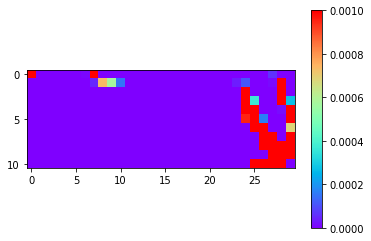

In [17]:
plt.imshow(frac, cmap='rainbow',vmin=0, vmax=1e-3)
plt.colorbar()

In [40]:
frac = frac/tot

0.0

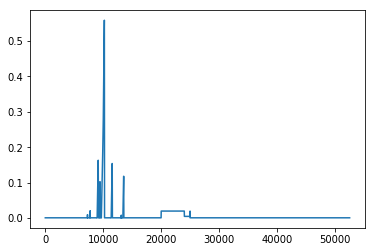

In [88]:
plt.imshow(frac)

In [85]:
ncvar_wt[20000:24000,0,0] = 0.02
ncvar_wt[24001:25000,0,0] = 0.005
ncvar_wt[25001:28000,0,0] = 0.001

In [86]:
nclu=NetCDFFile(fname,'r+')
nclu.variables['WT'][:,0,0] = ncvar_wt
nclu.close()